In [4]:
from Data.weatherbench_128_v2 import WeatherBench128
from Models.imvp_v2 import IAM4VP
from utils.metrics import Metrics

In [5]:
import torch
import numpy as np
import xarray as xr
import torch
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F

In [6]:
from torch.utils.data import DataLoader

In [7]:
import matplotlib.pyplot as plt

In [8]:
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

latents_size = [32, 64] # patch size = 4, input size [128, 256], latents size = [128/4, 256/4]

radius = 6371.0 * 1000
num_lat = latents_size[0] + 2
lat_t = torch.arange(start=0, end=num_lat)
latitudes = lat(lat_t, num_lat)[1:-1]
latitudes = latitudes/180*torch.pi

c_lats = 2*torch.pi*radius*torch.cos(latitudes)
c_lats = c_lats.reshape([1, 1, latents_size[0], 1])

pixel_x = c_lats/latents_size[1] # The actual distance each pixel corresponds to in the horizontal direction
pixel_y = torch.pi*radius/(latents_size[0]+1) # The actual distance each pixel corresponds to in the vertical direction

pressure = torch.tensor([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]).reshape([1, 13, 1, 1])
pixel_z = torch.tensor([50, 50, 50, 50, 50, 75, 100, 100, 100, 125, 112, 75, 75]).reshape([1, 13, 1, 1]) # The difference between adjacent pressure levels, which will be used to calculate the p-direction integral


pressure_level_num = pixel_z.shape[1]
M_z = torch.zeros(pressure_level_num, pressure_level_num)
for M_z_i in range(pressure_level_num):
    for M_z_j in range(pressure_level_num):
        if M_z_i <= M_z_j:
            M_z[M_z_i, M_z_j] = pixel_z[0, M_z_j, 0, 0]


In [9]:
train_start_time = '2000-01-01 00:00:00'
train_end_time = '2003-12-25 00:00:00' # '2000-01-01 23:00:00' #
val_start_time = '2004-01-01 00:00:00'
val_end_time = '2004-12-25 00:00:00' # '2004-01-01 23:00:00' #

train_data = WeatherBench128(start_time=train_start_time, end_time=train_end_time,
                            include_target=False, 
                            lead_time=1, 
                            interval=1,
                            muti_target_steps=1,
                            start_time_x=0,
                            end_time_x=120,      
                            start_time_y=12,
                            end_time_y=23)  
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=4)

In [ ]:
x_train, y_train = next(iter(train_loader))

In [ ]:
def x_to_zquvtw(x):
    """
    Преобразует входные данные x в формат zquvtw, пригодный для обработки через hybrid_block.

    Args:
        x: Входной тензор формы [B, C, H, W], где C - число каналов (обычно 65)

    Returns:
        zquvtw: Тензор формы [B, H//4, W//4, C] - пространственно понижающее преобразование и перестановка осей
    """
    # x имеет форму [B, C, H, W]
    B, C, H, W = x.shape

    # Понижающая дискретизация для уменьшения размера пространственных координат
    zquvtw = torch.nn.functional.interpolate(
        x, 
        size=(H//4, W//4), 
        mode='bilinear'
    )

    # Перестановка осей для формата [B, H, W, C], который ожидает HybridBlock
    # zquvtw = zquvtw.permute(0, 2, 3, 1)  # [B, H//4, W//4, C]

    return zquvtw

In [ ]:
# print(x_train[0, 0, 0].shape)

In [ ]:
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# x_1 = x_train[:, 1, 4:]
# x_1 = x_to_zquvtw(x_1)

In [ ]:
# x_0.shape

In [ ]:
# z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
# z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)

In [ ]:
latents_size = [32, 64] # patch size = 4, input size [128, 256], latents size = [128/4, 256/4]

radius = 6371.0 * 1000
num_lat = latents_size[0] + 2
lat_t = torch.arange(start=0, end=num_lat)
latitudes = lat(lat_t, num_lat)[1:-1]
latitudes = latitudes/180*torch.pi

c_lats = 2*torch.pi*radius*torch.cos(latitudes)
c_lats = c_lats.reshape([1, 1, latents_size[0], 1])

pixel_x = c_lats/latents_size[1] # The actual distance each pixel corresponds to in the horizontal direction
pixel_y = torch.pi*radius/(latents_size[0]+1) # The actual distance each pixel corresponds to in the vertical direction

pressure = torch.tensor([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]).reshape([1, 13, 1, 1])
pixel_z = torch.tensor([50, 50, 50, 50, 50, 75, 100, 100, 100, 125, 112, 75, 75]).reshape([1, 13, 1, 1]) # The difference between adjacent pressure levels, which will be used to calculate the p-direction integral


pressure_level_num = pixel_z.shape[1]
M_z = torch.zeros(pressure_level_num, pressure_level_num)
for M_z_i in range(pressure_level_num):
    for M_z_j in range(pressure_level_num):
        if M_z_i <= M_z_j:
            M_z[M_z_i, M_z_j] = pixel_z[0, M_z_j, 0, 0]


def integral_z(input_tensor):
    # Pressure-direction integral
    B, pressure_level_num, H, W = input_tensor.shape
    input_tensor = input_tensor.reshape(B, pressure_level_num, H*W)
    output = M_z.to(input_tensor.dtype).to(input_tensor.device) @ input_tensor
    output = output.reshape(B, pressure_level_num, H, W)
    return output


def d_x(input_tensor):
    # Latitude-direction differential
    B, C, H, W = input_tensor.shape
    conv_kernel = torch.zeros([1,1,1,5], device=input_tensor.device, dtype=input_tensor.dtype, requires_grad=False)
    conv_kernel[0,0,0,0] = 1
    conv_kernel[0,0,0,1] = -8
    conv_kernel[0,0,0,3] = 8
    conv_kernel[0,0,0,4] = -1

    input_tensor = torch.cat((input_tensor[:,:,:,-2:], 
                              input_tensor,
                              input_tensor[:,:,:,:2]), dim=3)
    _, _, H_, W_ = input_tensor.shape
    
    input_tensor = input_tensor.reshape(B*C, 1, H_, W_)
    output_x = F.conv2d(input_tensor, conv_kernel)/12
    output_x = output_x.reshape(B, C, H, W)
    output_x = output_x/pixel_x.to(output_x.dtype).to(output_x.device)
    
    return output_x


def d_y(input_tensor):
    # longitude-direction differential
    B, C, H, W = input_tensor.shape
    conv_kernel = torch.zeros([1,1,5,1], device=input_tensor.device, dtype=input_tensor.dtype, requires_grad=False)
    conv_kernel[0,0,0] = -1
    conv_kernel[0,0,1] = 8
    conv_kernel[0,0,3] = -8
    conv_kernel[0,0,4] = 1

    input_tensor = torch.cat((input_tensor[:,:,:2], 
                              input_tensor,
                              input_tensor[:,:,-2:]), dim=2)
    _, _, H_, W_ = input_tensor.shape
    
    input_tensor = input_tensor.reshape(B*C, 1, H_, W_)
    output_y = F.conv2d(input_tensor, conv_kernel)/12
    output_y = output_y.reshape(B, C, H, W)
    output_y = output_y/pixel_y
    
    return output_y


def d_z(input_tensor):
    # Pressure-direction differential
    conv_kernel = torch.zeros([1,1,5,1,1], device=input_tensor.device, dtype=input_tensor.dtype, requires_grad=False)
    conv_kernel[0,0,0] = -1
    conv_kernel[0,0,1] = 8
    conv_kernel[0,0,3] = -8
    conv_kernel[0,0,4] = 1

    input_tensor = torch.cat((input_tensor[:,:2], 
                              input_tensor,
                              input_tensor[:,-2:]), dim=1)
    
    input_tensor = input_tensor.unsqueeze(1) # B, 1, C, H, W
    output_z = F.conv3d(input_tensor, conv_kernel)/12
    output_z = output_z.squeeze(1)
    output_z = output_z/pixel_z.to(output_z.dtype).to(output_z.device)
    
    return output_z


class PDE_kernel(nn.Module):
    def __init__(self, variable_dim=13, block_dt=300, inverse_time=False, norm=False):
        super().__init__()
        self.norm = norm
        
        self.f = 7.29e-5
        self.L = 2.5e6
        self.R = 8.314
        self.c_p = 1005
        self.R_v = 461.5
        self.R_d = 287
        self.diff_ratio = 0.05
        self.block_dt = block_dt
        if inverse_time:
            self.block_dt = - self.block_dt

        self.norm_z = nn.BatchNorm2d(variable_dim)
        self.norm_q = nn.BatchNorm2d(variable_dim)
        self.norm_u = nn.BatchNorm2d(variable_dim)
        self.norm_v = nn.BatchNorm2d(variable_dim)
        self.norm_t = nn.BatchNorm2d(variable_dim)


    def scale_tensor(self, tensor, a, b):
        min_val = tensor.min().detach()
        max_val = tensor.max().detach()
        scaled_tensor = (tensor - min_val) / (max_val - min_val)
        scaled_tensor = scaled_tensor * (b - a) + a
        return scaled_tensor
    

    def scale_diff(self, diff_x, x):
        x_min, x_mean, x_max = x.min().detach(), x.mean().detach(), x.max().detach()
        diff_min = (x_min-x_mean) * self.diff_ratio
        diff_max = (x_max-x_mean) * self.diff_ratio
        diff_x = self.scale_tensor(diff_x, diff_min, diff_max)
        return diff_x
    
    def avoid_inf(self, tensor, threshold=1.0):
        tensor = torch.where(torch.abs(tensor) == 0.0, torch.ones_like(tensor)*0.1, tensor)
        tensor = torch.where(torch.abs(tensor) < threshold, torch.sign(tensor) * threshold, tensor)
        return tensor


    def share_z_dxyz(self, z):
        self.z_x = d_x(z)
        self.z_y = d_y(z)
        self.z_z = d_z(z)

    ############################# u v #############################
    def get_uv_dt(self, u, v, w):
        u_x = self.u_x
        u_y = d_y(u)
        u_z = d_z(u)

        v_x = d_x(v)
        v_y = self.v_y
        v_z = d_z(v)

        self.u_t = -u*u_x - v*u_y - w*u_z + self.f*v - self.z_x
        self.v_t = -u*v_x - v*v_y - w*v_z - self.f*u - self.z_y
        return self.u_t, self.v_t
    

    def uv_evolution(self, u, v, w):
        u_t, v_t = self.get_uv_dt(u, v, w)
        u = u + self.scale_diff(u_t*self.block_dt, u).detach()
        v = v + self.scale_diff(v_t*self.block_dt, v).detach()
        return u, v
    ################################################################
    
    ############################# t #############################
    def get_t_t(self, u, v, w, t):
        t_x = d_x(t)
        t_y = d_y(t)
        t_z = d_z(t)

        Q = -self.L*self.z_z*w
        self.t_t = (Q-self.z_z*w)/self.c_p - u*t_x - v*t_y - w*t_z
        return self.t_t
    
    def t_evolution(self, u, v, w, t):
        t_t = self.get_t_t(u, v, w, t)
        t = t + self.scale_diff(t_t*self.block_dt, t).detach()
        return t
    ################################################################

    ############################# z #############################
    def get_z_zt(self):    
        z_zt = -self.R/pressure.to(self.t_t.dtype).to(self.t_t.device)*self.t_t
        return z_zt
    
    def get_z_t(self):
        z_zt = self.get_z_zt()
        self.z_t = integral_z(z_zt)
        return self.z_t
    
    def z_evolution(self, z):
        z_t = self.get_z_t()
        z = z + self.scale_diff(z_t*self.block_dt, z).detach()
        return z
    ################################################################

    ############################# w #############################
    def get_w(self, u, v):
        self.u_x = d_x(u)
        self.v_y = d_y(v)
        w_z = - self.u_x - self.v_y
        w = integral_z(w_z).detach()
        return w
    ################################################################


    ############################# w #############################
    def get_q_dt(self, u, v, t, w, q):
        def get_qs(p, T):
            t = T - 273.15
            e_s = 6.112 * torch.exp(self.scale_tensor(17.67 * t / self.avoid_inf(t + 243.5), -3.47, 3.01)) * 100
            q_s = 0.622 * e_s / self.avoid_inf(p - 0.378 * e_s)
            return q_s

        def get_delta(p_t, q, q_s):
            cond = torch.logical_and(p_t < 0, torch.ge(q, q_s))
            return torch.where(cond, torch.ones_like(p_t), torch.zeros_like(p_t))

        def get_F(T, q, q_s):
            R = (1 + 0.608 * q) * self.R_d
            F_ = (self.L * R - self.c_p * self.R_v * T) / self.avoid_inf(self.c_p * self.R_v * T * T + self.L * self.L * q_s)
            F_ = F_ * q_s * T
            return F_

        q_x = d_x(q)
        q_y = d_y(q)
        q_z = d_z(q)

        rho = - 1/self.avoid_inf(self.z_z)
        p = rho*self.R*t

        q_s = get_qs(p, t).detach()
        q_s = torch.maximum(q_s, torch.ones_like(q_s)*1e-6)
        delta = get_delta(self.z_t + u*self.z_x + v*self.z_y + w*self.z_z, q, q_s).detach()
        F_ = get_F(t, q, q_s).detach()

        q_t =  -(u*q_x + v*q_y + w*q_z) + (self.z_t + u*self.z_x + v*self.z_y + w*self.z_z) * delta * F_ / self.avoid_inf(self.R*t)
        return q_t
    
    def q_evolution(self, u, v, t, w, q):
        q_t = self.get_q_dt(u, v, t, w, q)
        q = q + self.scale_diff(q_t*self.block_dt, q).detach()
        return q
    ################################################################


    def forward(self, zquvtw):
        # x [B, D, H, W]

        z_old, t_old, q_old, u_old, v_old = zquvtw.chunk(5, dim=1)

        w_old = self.get_w(u_old, v_old)
        self.share_z_dxyz(z_old)

        u_new, v_new = self.uv_evolution(u_old, v_old, w_old)
        t_new = self.t_evolution(u_old, v_old, w_old, t_old)
        z_new = self.z_evolution(z_old)
        q_new = self.q_evolution(u_old, v_old, t_old, w_old, q_old)
        if self.norm:
            z_new = self.norm_z(z_new)
            q_new = self.norm_q(q_new)
            u_new = self.norm_u(u_new)
            v_new = self.norm_v(v_new)
            t_new = self.norm_t(t_new)

        zquvtw_new = torch.cat([z_new, t_new, q_new, u_new, v_new], dim=1)
        
        return zquvtw_new

In [ ]:
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# x_1 = x_train[:, 1, 4:]
# x_1 = x_to_zquvtw(x_1)

# kernel = PDE_kernel(block_dt=1200)
# idx = 2

In [ ]:
# for i in range(3):
#     x_0 = kernel(x_0)
#     z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
#     plt.figure(figsize=(15, 5))  # Широкий формат для трёх графиков в ряд

#     # Первое изображение: u_0
#     plt.subplot(1, 3, 1)
#     plt.imshow(u_0[idx, 0].detach().numpy())
#     plt.title("integrated u_0")
#     plt.colorbar()

#     # Второе изображение: u_1
#     plt.subplot(1, 3, 2)
#     plt.imshow(u_1[idx, 0].detach().numpy())
#     plt.title("u_1")
#     plt.colorbar()

#     # Разница: |u_1 - u_0|
#     plt.subplot(1, 3, 3)
#     plt.imshow(np.abs(u_1[idx, 0].detach().numpy() - u_0[idx, 0].detach().numpy()))
#     plt.title("|u_1 - u_0|")
#     plt.colorbar()

#     plt.tight_layout()
#     plt.savefig(f"pics/u_{i}.png")

In [ ]:
# plt.figure(figsize=(15, 5))  # Широкий формат для трёх графиков в ряд

# # Первое изображение: u_0
# plt.subplot(1, 3, 1)
# plt.imshow(u_0[idx, 0].detach().numpy())
# plt.title("u_0")
# plt.colorbar()

# # Второе изображение: u_1
# plt.subplot(1, 3, 2)
# plt.imshow(u_1[idx, 0].detach().numpy())
# plt.title("u_1")
# plt.colorbar()

# # Разница: |u_1 - u_0|
# plt.subplot(1, 3, 3)
# plt.imshow(np.abs(u_1[idx, 0].detach().numpy() - u_0[idx, 0].detach().numpy()))
# plt.title("|u_1 - u_0|")
# plt.colorbar()

# plt.tight_layout()
# plt.show()

In [ ]:
import imageio
import os
import re

def save_gif_from_folder(folder="pics", pattern=r"(\d+)_u0\.png", filename="animation.gif", duration=0.2, trange=24):
    """
    Создаёт GIF из изображений в папке, соответствующих шаблону имени.

    Аргументы:
        folder (str): Папка, где лежат картинки
        pattern (str): Регулярное выражение для фильтрации и сортировки файлов
        filename (str): Имя выходного GIF-файла
        duration (float): Длительность одного кадра в секундах
    """
    files = []
    
    for i in range(trange):
        files.append((os.path.join(folder, f"u_{i}.png")))
    
    # Сортируем по индексу
    files.sort(key=lambda x: x[0])
    
    # Загружаем изображения
    frames = [imageio.imread(fpath) for fpath in files]
    
    # Сохраняем gif
    imageio.mimsave(filename, frames, duration=duration)
    print(f"GIF сохранён как {filename}")


In [ ]:
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()

In [19]:
u_mse_1200_bez = []
u_mae_1200_bez = []

v_mse_1200_bez = []
v_mae_1200_bez = []

z_mse_1200_bez = []
z_mae_1200_bez = []

q_mse_1200_bez = []
q_mae_1200_bez = []

t_mse_1200_bez = []
t_mae_1200_bez = []

kernel = PDE_kernel(block_dt=1200)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(3):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_1200_bez.append(mse_loss(u_0, u_1).item())
    u_mae_1200_bez.append(mae_loss(u_0, u_1).item())
    
    v_mse_1200_bez.append(mse_loss(v_0, v_1).item())
    v_mae_1200_bez.append(mae_loss(v_0, v_1).item())
    
    q_mse_1200_bez.append(mse_loss(q_0, q_1).item())
    q_mae_1200_bez.append(mae_loss(q_0, q_1).item())
    
    t_mse_1200_bez.append(mse_loss(t_0, t_1).item())
    t_mae_1200_bez.append(mae_loss(t_0, t_1).item())
    
    z_mse_1200_bez.append(mse_loss(z_0, z_1).item())
    z_mae_1200_bez.append(mae_loss(z_0, z_1).item())
    
    

In [ ]:
u_mse_300_bez = []
u_mae_300_bez = []

v_mse_300_bez = []
v_mae_300_bez = []

z_mse_300_bez = []
z_mae_300_bez = []

q_mse_300_bez = []
q_mae_300_bez = []

t_mse_300_bez = []
t_mae_300_bez = []

kernel = PDE_kernel(block_dt=300)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(110):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(12):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_300_bez.append(mse_loss(u_0, u_1).item())
    u_mae_300_bez.append(mae_loss(u_0, u_1).item())
    
    v_mse_300_bez.append(mse_loss(v_0, v_1).item())
    v_mae_300_bez.append(mae_loss(v_0, v_1).item())
    
    q_mse_300_bez.append(mse_loss(q_0, q_1).item())
    q_mae_300_bez.append(mae_loss(q_0, q_1).item())
    
    t_mse_300_bez.append(mse_loss(t_0, t_1).item())
    t_mae_300_bez.append(mae_loss(t_0, t_1).item())
    
    z_mse_300_bez.append(mse_loss(z_0, z_1).item())
    z_mae_300_bez.append(mae_loss(z_0, z_1).item())
    

In [21]:
u_mse_1200 = []
u_mae_1200 = []

v_mse_1200 = []
v_mae_1200 = []

z_mse_1200 = []
z_mae_1200 = []

q_mse_1200 = []
q_mae_1200 = []

t_mse_1200 = []
t_mae_1200 = []

kernel = PDE_kernel(block_dt=1200, norm=True)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(3):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_1200.append(mse_loss(u_0, u_1).item())
    u_mae_1200.append(mae_loss(u_0, u_1).item())
    
    v_mse_1200.append(mse_loss(v_0, v_1).item())
    v_mae_1200.append(mae_loss(v_0, v_1).item())
    
    q_mse_1200.append(mse_loss(q_0, q_1).item())
    q_mae_1200.append(mae_loss(q_0, q_1).item())
    
    t_mse_1200.append(mse_loss(t_0, t_1).item())
    t_mae_1200.append(mae_loss(t_0, t_1).item())
    
    z_mse_1200.append(mse_loss(z_0, z_1).item())
    z_mae_1200.append(mae_loss(z_0, z_1).item())

In [22]:
u_mse_300 = []
u_mae_300 = []

v_mse_300 = []
v_mae_300 = []

z_mse_300 = []
z_mae_300 = []

q_mse_300 = []
q_mae_300 = []

t_mse_300 = []
t_mae_300 = []

kernel = PDE_kernel(block_dt=300, norm=True)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(12):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_300.append(mse_loss(u_0, u_1).item())
    u_mae_300.append(mae_loss(u_0, u_1).item())
    
    v_mse_300.append(mse_loss(v_0, v_1).item())
    v_mae_300.append(mae_loss(v_0, v_1).item())
    
    q_mse_300.append(mse_loss(q_0, q_1).item())
    q_mae_300.append(mae_loss(q_0, q_1).item())
    
    t_mse_300.append(mse_loss(t_0, t_1).item())
    t_mae_300.append(mae_loss(t_0, t_1).item())
    
    z_mse_300.append(mse_loss(z_0, z_1).item())
    z_mae_300.append(mae_loss(z_0, z_1).item())

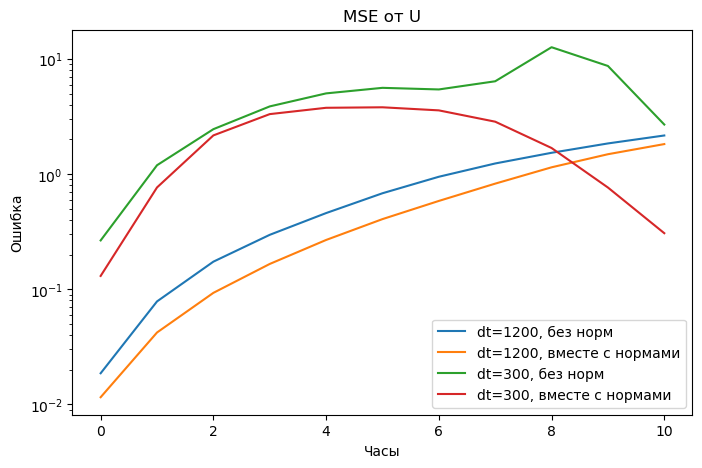

In [23]:
plt.figure(figsize=(8, 5))
plt.title("MSE от U")
plt.plot(u_mse_1200_bez, label='dt=1200, без норм')
plt.plot(u_mse_1200, label='dt=1200, вместе с нормами')
plt.plot(u_mse_300_bez, label='dt=300, без норм')
plt.plot(u_mse_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()


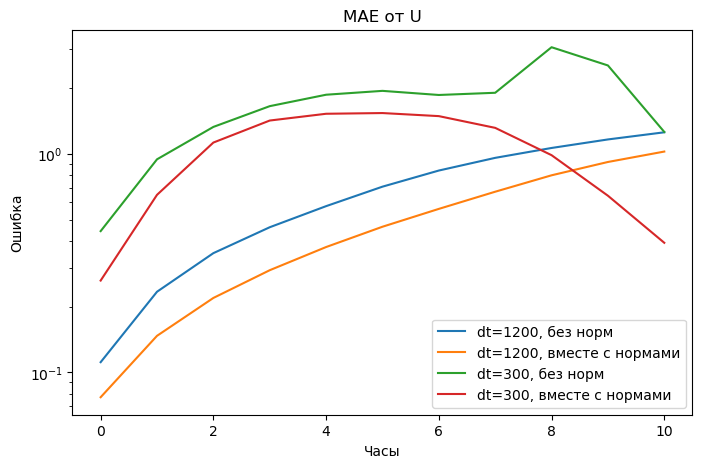

In [24]:
plt.figure(figsize=(8, 5))
plt.title("MАE от U")
plt.plot(u_mae_1200_bez, label='dt=1200, без норм')
plt.plot(u_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(u_mae_300_bez, label='dt=300, без норм')
plt.plot(u_mae_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

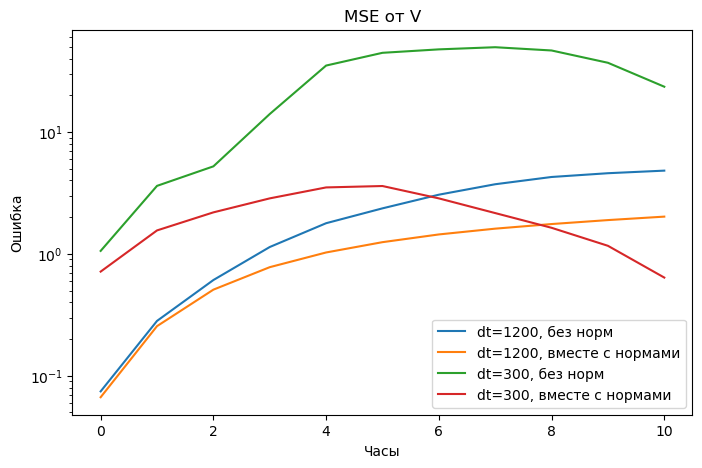

In [25]:
plt.figure(figsize=(8, 5))
plt.title("MSE от V")
plt.plot(v_mse_1200_bez, label='dt=1200, без норм')
plt.plot(v_mse_1200, label='dt=1200, вместе с нормами')
plt.plot(v_mse_300_bez, label='dt=300, без норм')
plt.plot(v_mse_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

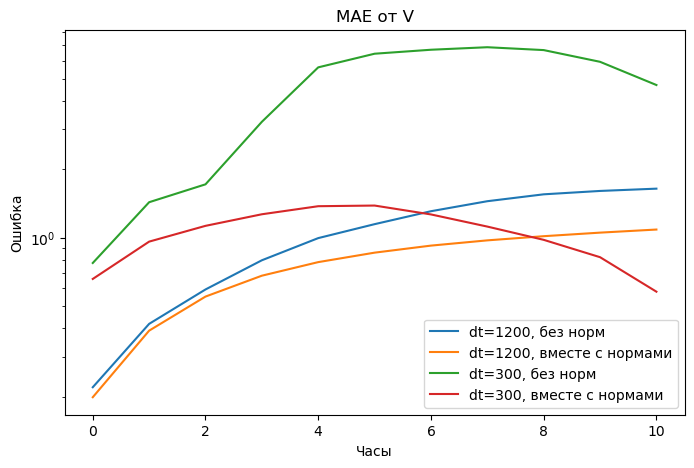

In [26]:
plt.figure(figsize=(8, 5))
plt.title("MАE от V")
plt.plot(v_mae_1200_bez, label='dt=1200, без норм')
plt.plot(v_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(v_mae_300_bez, label='dt=300, без норм')
plt.plot(v_mae_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

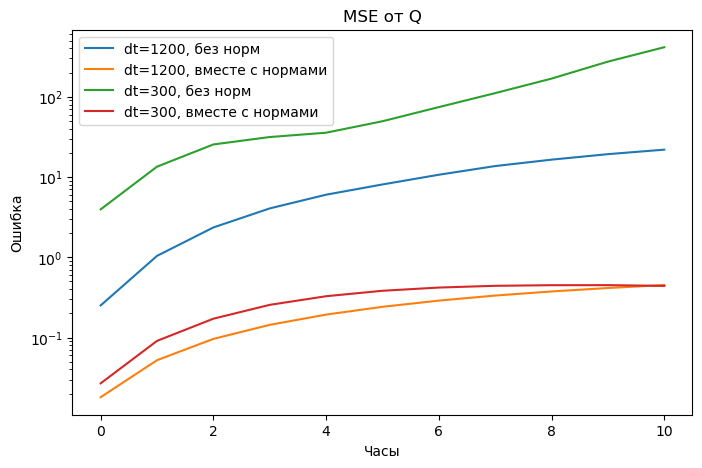

In [27]:
plt.figure(figsize=(8, 5))
plt.title("MSE от Q")
plt.plot(q_mse_1200_bez, label='dt=1200, без норм')
plt.plot(q_mse_1200, label='dt=1200, вместе с нормами')
plt.plot(q_mse_300_bez, label='dt=300, без норм')
plt.plot(q_mse_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

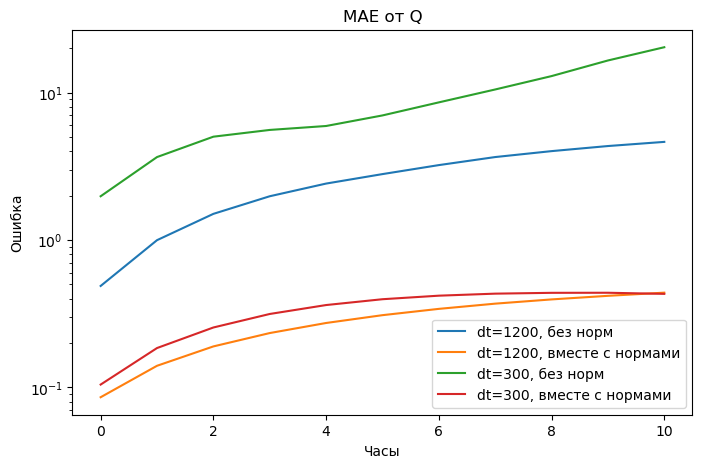

In [28]:
plt.figure(figsize=(8, 5))
plt.title("MАE от Q")
plt.plot(q_mae_1200_bez, label='dt=1200, без норм')
plt.plot(q_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(q_mae_300_bez, label='dt=300, без норм')
plt.plot(q_mae_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

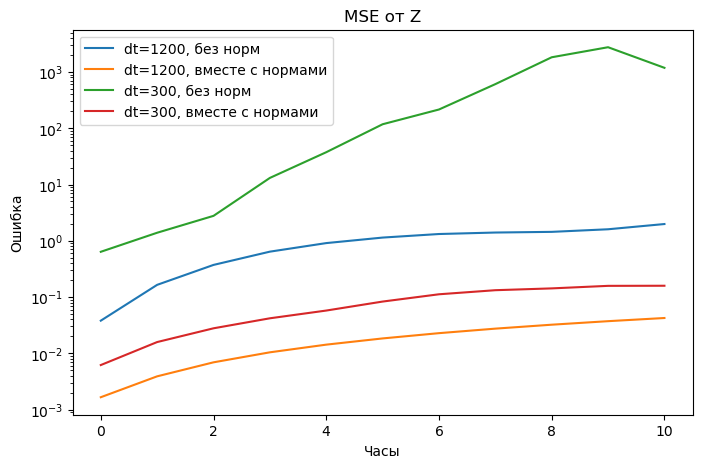

In [29]:
plt.figure(figsize=(8, 5))
plt.title("MSE от Z")
plt.plot(z_mse_1200_bez, label='dt=1200, без норм')
plt.plot(z_mse_1200, label='dt=1200, вместе с нормами')
plt.plot(z_mse_300_bez, label='dt=300, без норм')
plt.plot(z_mse_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

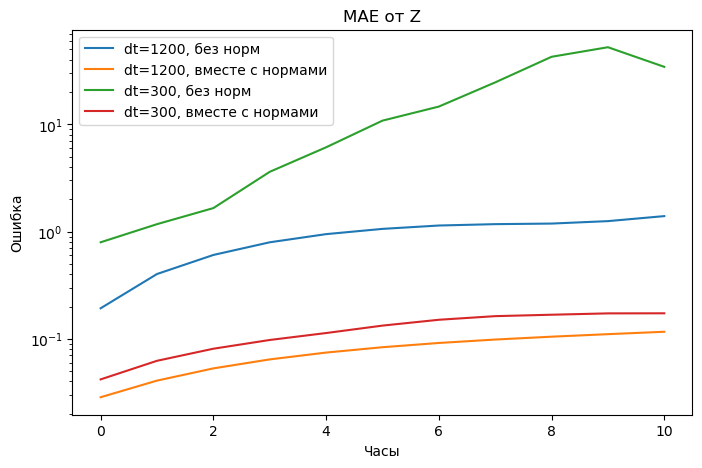

In [30]:
plt.figure(figsize=(8, 5))
plt.title("MАE от Z")
plt.plot(z_mae_1200_bez, label='dt=1200, без норм')
plt.plot(z_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(z_mae_300_bez, label='dt=300, без норм')
plt.plot(z_mae_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

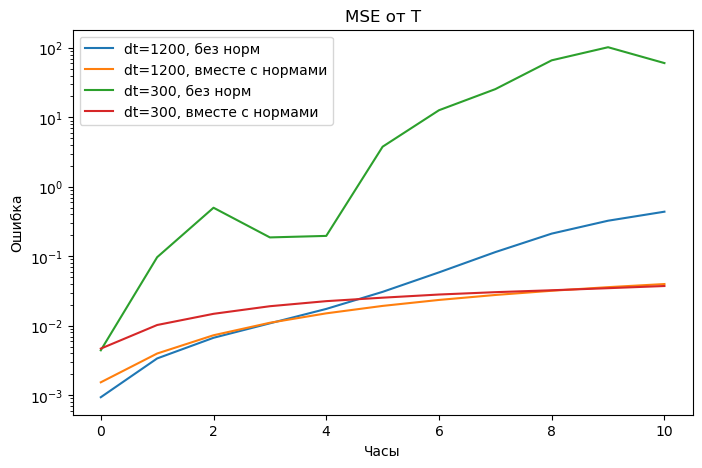

In [31]:
plt.figure(figsize=(8, 5))
plt.title("MSE от T")
plt.plot(t_mse_1200_bez, label='dt=1200, без норм')
plt.plot(t_mse_1200, label='dt=1200, вместе с нормами')
plt.plot(t_mse_300_bez, label='dt=300, без норм')
plt.plot(t_mse_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

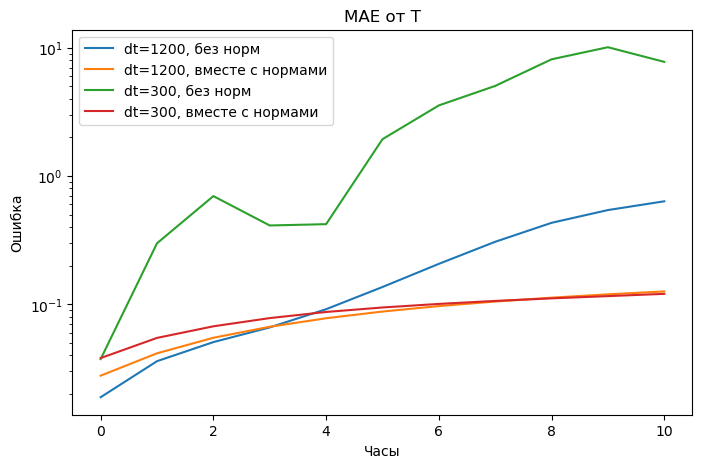

In [32]:
plt.figure(figsize=(8, 5))
plt.title("MАE от T")
plt.plot(t_mae_1200_bez, label='dt=1200, без норм')
plt.plot(t_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(t_mae_300_bez, label='dt=300, без норм')
plt.plot(t_mae_300, label='dt=300, вместе с нормами')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

In [36]:
import pandas as pd

In [ ]:
df_t_mae = pd.DataFrame({"t_mae_1200_bez": t_mae_1200_bez,
                         "t_mae_1200": t_mae_1200,
                         "t_mae_300_bez": t_mae_300_bez,
                         "t_mae_300": t_mae_300,
                            })
df_t_mae.to_csv("df_t_mae.csv")

df_t_mse = pd.DataFrame({"t_mse_1200_bez": t_mse_1200_bez,
                         "t_mse_1200": t_mse_1200,
                         "t_mse_300_bez": t_mse_300_bez,
                         "t_mse_300": t_mse_300,
                            })
df_t_mse.to_csv("df_t_mse.csv")

In [ ]:
df_u_mae = pd.DataFrame({"u_mae_1200_bez": u_mae_1200_bez,
                         "u_mae_1200": u_mae_1200,
                         "u_mae_300_bez": u_mae_300_bez,
                         "u_mae_300": u_mae_300,
                            })
df_u_mae.to_csv("df_u_mae.csv")

df_u_mse = pd.DataFrame({"u_mse_1200_bez": u_mse_1200_bez,
                         "u_mse_1200": u_mse_1200,
                         "u_mse_300_bez": u_mse_300_bez,
                         "u_mse_300": u_mse_300,
                            })
df_u_mse.to_csv("df_u_mse.csv")

In [ ]:
df_v_mae = pd.DataFrame({"v_mae_1200_bez": v_mae_1200_bez,
                         "v_mae_1200": v_mae_1200,
                         "v_mae_300_bez": v_mae_300_bez,
                         "v_mae_300": v_mae_300,
                            })
df_v_mae.to_csv("df_v_mae.csv")

df_v_mse = pd.DataFrame({"v_mse_1200_bez": v_mse_1200_bez,
                         "v_mse_1200": v_mse_1200,
                         "v_mse_300_bez": v_mse_300_bez,
                         "v_mse_300": v_mse_300,
                            })
df_v_mse.to_csv("df_v_mse.csv")

In [ ]:
df_q_mae = pd.DataFrame({"q_mae_1200_bez": q_mae_1200_bez,
                         "q_mae_1200": q_mae_1200,
                         "q_mae_300_bez": q_mae_300_bez,
                         "q_mae_300": q_mae_300,
                            })
df_q_mae.to_csv("df_q_mae.csv")

df_q_mse = pd.DataFrame({"q_mse_1200_bez": q_mse_1200_bez,
                         "q_mse_1200": q_mse_1200,
                         "q_mse_300_bez": q_mse_300_bez,
                         "q_mse_300": q_mse_300,
                            })
df_q_mse.to_csv("df_q_mse.csv")

In [ ]:
df_z_mae = pd.DataFrame({"z_mae_1200_bez": z_mae_1200_bez,
                         "z_mae_1200": z_mae_1200,
                         "z_mae_300_bez": z_mae_300_bez,
                         "z_mae_300": z_mae_300,
                            })
df_z_mae.to_csv("df_z_mae.csv")

df_z_mse = pd.DataFrame({"z_mse_1200_bez": z_mse_1200_bez,
                         "z_mse_1200": z_mse_1200,
                         "z_mse_300_bez": z_mse_300_bez,
                         "z_mse_300": z_mse_300,
                            })
df_z_mse.to_csv("df_z_mse.csv")